In [7]:
# test file implementation of regularization of damage (d) using lipschitz constraints
import numpy as np
import scipy
import copy
from sortedcontainers import SortedList
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint


### Material and geometry inputs

In [8]:
# Material parameters
E = 275.0*10**9     # Young's module (Pa)
Gc = 50.0          # Fracture energy

# Geometry parameters
L = 1.05*10**-3     # Bar length
x0 = 0              # Left extremitiy x coordinate / 0-initial
xf = L              # Rigth extremitiy x coordinate / f-final

# Mesh
n_el = 21           # Number of elements
hun = L/n_el        # Element length
# Points coordinates for a uniform mesh
node_coord = np.linspace(x0, xf, n_el+1)
# Coordenates of integration points
x = [hun*i + hun*0.5 for i in range(n_el)]

# Data for test damage peak at the middle of the bar
# A fabricated damage field
dn = [0., 0.0473944, 0.0898275, 0.127299, 0.15981, 0.187359, 0.209947, 0.227574,  0.24024,  0.247944,0.250687, 0.248469, 0.24129,  0.229149, 0.212047, 0.189984, 0.16296, 0.127299, 0.0898275, 0.0473944, 0.]

# dsym =( np.array(dn) + np.array(dn[ : : -1])) * 0.5
# dn = dsym

# A fabricate critical stress field
stress_critical = 300.0*10**4
sigmac = [(abs(node_coord[i]-L/2)**0.5)/((L/2)**0.5 /
                                         (stress_critical*3)) + stress_critical for i in range(n_el)]

# sigmac_sym =( np.array(sigmac) + np.array(sigmac[ : : -1])) * 0.5
# sigmac = sigmac_sym


strain = 5*10**-5  # Assuming constant strain


### Inputs regaring the regularization of damage 

In [9]:
n_element_reg = 20         # Number of elements in the regularization 
l = n_element_reg * hun     # Regularization length
w = 2.                      # Weight quadrature

# Energy release rate
Yc = [sigmac[el]**2 / (2.*E) for el in range(n_el)] 
# Constant lambda 
lamb = [2. * Yc[el] * l / Gc for el in range(n_el)]  
# Softening function
def h(lamb,d): return (2*d - d**2) / (1 - d + lamb * d**2) **2

# Functional to minimize considering the whole domain as input
def functionalDomain(d):
    """Returns the fuctional for the domain.""" 
    return w*sum([
            (0.5*(1. - d[el])** 2 * 
            E*strain**2 + 
            Yc[el] * 
            h(lamb[el], d[el])) * 
            hun/2.
            for el in range(n_el)
    ])


def functionalSubdomain(d, region_optimization): 
    """Returns the functional for a given subdomain."""
    return w*sum([
    (0.5*(1. - d[i])** 2 * 
    E*strain**2 + 
    Yc[region_optimization[i]] * 
    h(lamb[region_optimization[i]], d[i])) * 
    hun/2.
    for i in range(len(region_optimization))
    ])


### Compute projections solving the optimization problem with scipy (algorithm 1)

In [10]:
def ComputeProjectionsOptimization(damage_predictor):
    """Returns the upper and lower projection of the damage predictor by solving an optimization problem with scipy"""
    
    lower_projection = np.zeros(n_el)
    upper_projection = np.zeros(n_el)

    for el in range(n_el):
        upper_optmization = minimize(
            lambda y: -damage_predictor[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
            x0=0.5*L,
            method='SLSQP',
            bounds=[(x0, xf)],
            tol=1e-6
        )
        if upper_optmization.success == False:
            raise Exception('upper projection damage predictor failed')
        upper_projection[el] = - upper_optmization.fun

        lower_optmization = minimize(
            lambda y: damage_predictor[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
            x0=0.5*L,
            method='SLSQP',
            bounds=[(x0, xf)],
            tol=1e-6
        )
        if lower_optmization.success == False:
            raise Exception('lower projection damage predictor failed')
        lower_projection[el] = lower_optmization.fun
    
    return upper_projection, lower_projection

### Compute projections as in GEM algorithm ( algorithm 2 )

In [11]:
def get_neighbour(index):
    if index == 0:
        return [0]
    if index == n_el - 1:
        return [index - 1]
    return [index - 1, index + 1]


def computeProjections_FM_lip_projector_1D(damage_predictor, regularization_lenght, flank):
    
    # Let's assume initially the projection equal to the damage predictor
    projection = damage_predictor.copy()

    # Configure key for trial set according to the projection if upper (flank=max) or lower (flank=min)
    if flank == "min":
        trial_set = SortedList(key=lambda x: (-x[0], x[1]))
    else:
        trial_set = SortedList()

    # Add all elements to the trial set
    for index, projection_value in enumerate(projection):
        trial_set.add((projection_value, index))

    # Initialize the frozen set 
    frozen_set = set()

    while len(trial_set) > 0:

        projection_current_index, index = trial_set.pop()
        frozen_set.add(index)
        neighbours = get_neighbour(index)

        for index_neighbour in neighbours:
            if index_neighbour not in frozen_set:      
                update_projection_value = False

                delta_projection = (projection[index_neighbour] - projection_current_index) / hun * regularization_lenght 

                if delta_projection < -1.0:
                    update_projection_value = True
                    new_projection = projection_current_index - hun /  regularization_lenght

                elif delta_projection > 1.0:
                    update_projection_value = True
                    new_projection = projection_current_index + hun / regularization_lenght

                if update_projection_value == True:
                    projection[index_neighbour] = new_projection
                    trial_set.discard((projection[index_neighbour], index_neighbour))
                    trial_set.add((new_projection, index_neighbour))

    return projection

### Compute damage using the projections

In [12]:
# Initialize variables
d_next1 = np.zeros(n_el)
d_next2 = np.zeros(n_el)
small_number = 10e-5
# in region_opt store the element index for the region used in the optimization
region_opt1 = []
region_opt2 = []
# dn_region_opt returns a list with the damage at time-step n for the elements in the region used in the optimization
dn_region_opt1 = []
dn_region_opt2 = []


# Compute damage predictor: Optimization without constraints for the whole domain
damage_predictor_optmization = minimize(
    fun=functionalDomain,
    x0=dn,
    method='SLSQP',
    bounds=zip(dn, [1.]*n_el),
    tol=1e-6,
)
if damage_predictor_optmization.success == False:
    raise Exception('optimization damage predictor failed')

damage_predictor = damage_predictor_optmization.x


# Compute damage predictions projections
upper_algorithm1, lower_algorithm1 = ComputeProjectionsOptimization(damage_predictor)
upper_algorithm2 = computeProjections_FM_lip_projector_1D(damage_predictor, l, flank="max")
lower_algorithm2 = computeProjections_FM_lip_projector_1D(damage_predictor, l, flank="min")




for el in range(n_el):

    # If projections are superposed
    if (upper_algorithm1[el] - lower_algorithm1[el] < small_number):
        d_next1[el] = damage_predictor[el]


    # If the projections are different
    else:
        # Add element to region used in the otpimization
        region_opt1.append(el)
        dn_region_opt1.append(dn[el])
    
    
    # If projections are superposed
    if (upper_algorithm2[el] - lower_algorithm2[el] < small_number):
        d_next2[el] = damage_predictor[el]


    # If the projections are different
    else:
        # Add element to region used in the otpimization
        region_opt2.append(el)
        dn_region_opt2.append(dn[el])



functional1 = lambda damage: functionalSubdomain(damage, region_opt1)
functional2 = lambda damage: functionalSubdomain(damage, region_opt2)
size1 = len(region_opt1)
size2 = len(region_opt2)

print(region_opt1)
print(region_opt2)

if size1 > 1:

    A1 = scipy.sparse.eye(size1 - 1, size1) - scipy.sparse.eye(size1 - 1, size1, 1)
    b1 = hun/l
    const1 = LinearConstraint(A1, -b1 * np.ones(size1-1), b1 * np.ones(size1-1))
    # Bounds
    bound_inf1 = [dn[region_opt1[i]] for i in range(size1)]
    bound_sup1= [1. for i in range(size1)]



    dlip_optmization1 = minimize(
        fun=functional1,
        x0=bound_inf1,
        method='SLSQP',
        bounds=zip(bound_inf1, bound_sup1),
        tol=1e-6,
        constraints=const1,
    )
    if dlip_optmization1.success == False:
        raise Exception('optimization failed')
        
    d_opt1 = dlip_optmization1.x

    # Fill the region of the optimization in the damage array
    for i in range(size1):
        d_next1[region_opt1[i]] = d_opt1[i]



if size2 > 2:

    A2 = scipy.sparse.eye(size2 - 1, size2) - scipy.sparse.eye(size2 - 1, size2, 1)
    b2 = hun/l
    const2 = LinearConstraint(A2, -b2 * np.ones(size2-1), b2 * np.ones(size2-1))
    # Bounds
    bound_inf2 = [dn[region_opt2[i]] for i in range(size2)]
    bound_sup2 = [1. for i in range(size2)]



    dlip_optmization2 = minimize(
        fun=functional2,
        x0=bound_inf2,
        method='SLSQP',
        bounds=zip(bound_inf2, bound_sup2),
        tol=1e-6,
        constraints=const2,
    )
    if dlip_optmization2.success == False:
        raise Exception('optimization failed')
        
    d_opt2 = dlip_optmization2.x

    # Fill the region of the optimization in the damage array
    for i in range(size2):
        d_next2[region_opt2[i]] = d_opt2[i]

[4, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[7, 8, 9, 10, 11, 12, 13, 14, 15]


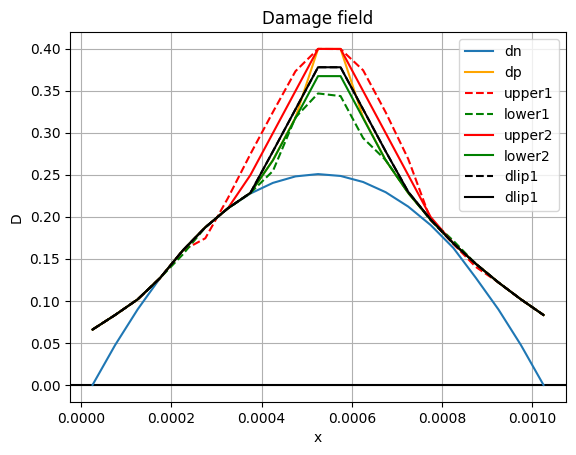

In [16]:
# Plot

def PlotDamage(x, dn, damage_predictor, upper1, lower1, upper2, lower2, dlip1, dlip2):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')

    plt.title(str("Damage field"))
    plt.xlabel(str("x"))
    plt.ylabel(str("D"))
    plt.plot(x, dn, label='dn')
    plt.plot(x, damage_predictor, label='dp', color='orange')
    plt.plot(x, upper1, label='upper1', color='red', linestyle = 'dashed')
    plt.plot(x, lower1, label='lower1', color='green', linestyle = 'dashed')
    plt.plot(x, upper2, label='upper2', color='red')
    plt.plot(x, lower2, label='lower2', color='green')
    plt.plot(x, dlip1, label='dlip1', color='black', linestyle = 'dashed')
    plt.plot(x, dlip2, label='dlip1', color='black')
    plt.legend()
    # plt.savefig("test_projections_algorithms.svg")
    plt.show()

# PlotDamage(x, dn, dp, upper, lower, d_next, upper_proj, lower_proj)
PlotDamage(x, dn, damage_predictor, upper_algorithm1, lower_algorithm1, upper_algorithm2, lower_algorithm2, d_next1, d_next2)